In [ ]:
import os; os.environ['ACCELERATE_DISABLE_RICH'] = "1"
import sys
import einops
from dataclasses import dataclass

from transformer_lens.utils import gelu_new, tokenize_and_concatenate
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

import torch
import torch as t
from torch import Tensor
import torch.nn as nn
import numpy as np
import math
from tqdm.notebook import tqdm
from typing import Tuple, List, Optional, Dict, Callable
from jaxtyping import Float, Int
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast
from collections import defaultdict
from rich.table import Table
from rich import print as rprint
import datasets
from torch.utils.data import DataLoader
import wandb
from pathlib import Path
import webbrowser

# Make sure exercises are in the path
chapter = r"chapter1_transformer_interp"
directory = "/Users/daniellee/Desktop/projects/arena_transformer/ARENA_3.0/"
exercises_dir = Path(f"{directory.split(chapter)[0]}/{chapter}/exercises").resolve()
section_dir = exercises_dir / "part1_transformer_from_scratch"
if str(exercises_dir) not in sys.path: sys.path.append(str(exercises_dir))

if t.backends.mps.is_available():
    print("current PyTorch install was "
              "built with MPS enabled.")
    if t.backends.mps.is_built():
        print("MPS is available")
        device = t.device("mps")
else:
    device = t.device("cuda" if t.cuda.is_available() else "cpu")

MAIN = __name__ == '__main__'

reference_gpt2 = HookedTransformer.from_pretrained(
    "gpt2-small",
    fold_ln=False,
    center_unembed=False,
    center_writing_weights=False,
)

import circuitsvis as cv

from plotly_utils import imshow, hist, plot_comp_scores, plot_logit_attribution, plot_loss_difference

from typing import List, Optional, Callable, Tuple, Dict, Literal, Set, Union
from plotly_utils import imshow, line, scatter, bar
from rich.table import Table, Column
from rich import print as rprint
from IPython.display import display, HTML
import string
import pandas as pd
from functools import partial


## https://github.com/philipperemy/name-dataset
from names_dataset import NameDataset, NameWrapper
nd = NameDataset()
import random

# Step 1: Find Behavior
# First, I want to check that the behavior I want exists

## Generate random set of names with token length == 1

In [324]:
df = pd.DataFrame(nd.get_top_names(n=500, country_alpha2='US')['US']["M"], columns = ["names"])
df["type"] = "first"

df_f = pd.DataFrame(nd.get_top_names(n=500, country_alpha2='US')['US']["F"], columns = ["names"])
df_f["type"] = "first"

df = pd.concat([df, df_f])

df_last = pd.DataFrame(nd.get_top_names(n=1500, country_alpha2='US', use_first_names = False)['US'], columns = ["names"])
df_last["type"] = "last"

df = pd.concat([df, df_last])


df["string"] = " " + df["names"]
df["string_lower"] = df["string"].str.lower()
df["names_lower"] = df["names"].str.lower()

df["token"] = df.apply(lambda x: model.to_tokens(x["string"], prepend_bos=False).size(1), axis=1)
df["token_names"] = df.apply(lambda x: model.to_tokens(x["names"], prepend_bos=False).size(1), axis=1)
df["token_lower"] = df.apply(lambda x: model.to_tokens(x["string_lower"], prepend_bos=False).size(1), axis=1)
df["token_names_lower"] = df.apply(lambda x: model.to_tokens(x["names_lower"], prepend_bos=False).size(1), axis=1)

first_names = list(df[(df["token_lower"] == 1) & (df["type"] == "first")]["names"])

last_names = list(df[(df["token_names"] == 1) & (df["token_names_lower"] == 1) & (df["token_lower"] == 1) & (df["type"] == "last")]["names"])

In [325]:
## remove some names where the first letter ends up becoming a more predicted token than the name
remove_list = ["cris", "guy", "barb", "chase", "will"]

In [326]:
## create a class for generating text
## I want to create a text where we convert name to email-stype names.
text = '''Katy Johnson -> katy_johnson
Bill Biden -> bill_biden
Bob Lee -> bob_lee
John Murray -> john_murray
Camila Park -> camila_park'''

class name_email_text:
    def __init__(self, name_count):
        self.name_counts = name_count

    def generate_text(self):
        text = ""
        for i in range(self.name_counts):
            first_name, last_name = self.get_random_name()
            line = self.generate_line(first_name, last_name)
            text += line
        return text

    def remove_final_name(self, text):
        return " -> ".join(text.split(" -> ")[:-1]) + " ->"

    def get_final_firstname_lowercase(self, text):
        return text.split(" ->")[-1].split("_")[0]
        
    def get_random_name(self):
        first_name = random.choice(list(set(first_names) - set(remove_list)))
        last_name = random.choice(last_names)
        
        return first_name, last_name

    def generate_line(self, first_name, last_name):
        return f" {first_name} {last_name} -> {first_name.lower()}_{last_name.lower()}@gmail.com\n"

In [327]:
text_generator = name_email_text(5)

text = text_generator.generate_text()

text

' Rose Love -> rose_love@gmail.com\n Art Song -> art_song@gmail.com\n Prince Ward -> prince_ward@gmail.com\n Art Ann -> art_ann@gmail.com\n Hope Rock -> hope_rock@gmail.com\n'

In [328]:
print(text)

 Rose Love -> rose_love@gmail.com
 Art Song -> art_song@gmail.com
 Prince Ward -> prince_ward@gmail.com
 Art Ann -> art_ann@gmail.com
 Hope Rock -> hope_rock@gmail.com



## 1.1 Let's test behavior on gpt2-small

In [329]:
gpt2_small = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

loss = gpt2_small(text, return_type="loss")
print("Model loss:", loss)

Loaded pretrained model gpt2-small into HookedTransformer
Model loss: tensor(3.2169, device='mps:0', grad_fn=<NegBackward0>)


In [330]:
logits: Tensor = gpt2_small(text, return_type="logits")
prediction = logits.argmax(dim=-1).squeeze()[:-1]

print("prediction output:")
print(gpt2_small.to_string(prediction))
true_tokens = gpt2_small.to_tokens(text).squeeze()[1:]
num_correct = (prediction == true_tokens).sum()
print(f"Model accuracy: {num_correct}/{len(true_tokens)}")

prediction output:

maryll I.love
hot.com

work by Art_song@gmail.com

 -> -> prince_ward@gmail.com

 Songoun art_ann@gmail.com

 Song -> hope_rock@gmail.com

Model accuracy: 37/55


<span style="color: blue;"> We can see that, for gpt2_small we are starting to generate correct prediciton starting from the third name or sometimes the second name. Does it work for a smaller model?

## 1.2 Test behavior in smaller models

### Attention only 4L Model

In [331]:
model: HookedTransformer = HookedTransformer.from_pretrained("attn-only-4l")

Loaded pretrained model attn-only-4l into HookedTransformer


In [332]:
logits: Tensor = model(text, return_type="logits")
prediction = logits.argmax(dim=-1).squeeze()[:-1]

print("prediction output:")
print(model.to_string(prediction))
true_tokens = model.to_tokens(text).squeeze()[1:]
num_correct = (prediction == true_tokens).sum()
print(f"Model accuracy: {num_correct}/{len(true_tokens)}")

prediction output:
.,, The RoseRose_red.com.# of Song " Songsong_gmail.com
Art ofrobe Art Wardsong:gmail.com

 Songounce artist_songiversarygmail.com
 Art to & art Rocksong_gmail.com

Model accuracy: 20/55


### 4L Solu model

In [333]:
model: HookedTransformer = HookedTransformer.from_pretrained("solu-4l")

Loaded pretrained model solu-4l into HookedTransformer


In [334]:
logits: Tensor = model(text, return_type="logits")
prediction = logits.argmax(dim=-1).squeeze()[:-1]

print("prediction output:")
print(model.to_string(prediction))
true_tokens = model.to_tokens(text).squeeze()[1:]
num_correct = (prediction == true_tokens).sum()
print(f"Model accuracy: {num_correct}/{len(true_tokens)}")

prediction output:
.mary, Rose.love_rose.com.# of: Rose_song@gmail.com
 Art -> -> Prince_love@gmail.com

 Songounce art_song@gmail.com
 Art this -> art_rock@gmail.com

Model accuracy: 32/55


### 4L Solu wiki model

In [335]:
model: HookedTransformer = HookedTransformer.from_pretrained("solu-4l-wiki")

Loaded pretrained model solu-4l-wiki into HookedTransformer


In [336]:
logits: Tensor = model(text, return_type="logits")
prediction = logits.argmax(dim=-1).squeeze()[:-1]

print("prediction output:")
print(model.to_string(prediction))
true_tokens = model.to_tokens(text).squeeze()[1:]
num_correct = (prediction == true_tokens).sum()
print(f"Model accuracy: {num_correct}/{len(true_tokens)}")

prediction output:

mary, "
love

.com

 of ( rose-music
gmail.com

 of -> art
love
gmail.com

 Songounce art_songouncegmail.com

 & -> art-rock
gmail.com

Model accuracy: 25/55


<span style="color: blue;"> We can see that it doesn't work that well for 4L models. 
Seems like something more complicated than induction circuit is going on

# Step 2: Perform Direct Logit Attribution

In [337]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Loaded pretrained model gpt2-small into HookedTransformer


In [338]:
class prompt_input:
    def __init__(self, model, prompts, name_pairs):
        self.model = model
        
        self.prompts = prompts
        ## I include token length to not care too much that the token lengths need to be the same
        self.token_length = torch.Tensor([model.to_tokens(x, prepend_bos=True).size(1) for x in prompts]).int()
        self.tokens = (model.to_tokens(prompts, prepend_bos=True)).to(device)

        self.original_logits, self.cache = model.run_with_cache(self.tokens)
        ##self.original_logits have the shape Float[Tensor, "batch seq d_vocab"]
        
        self.answers = name_pairs
        self.answer_tokens = t.concat([
            model.to_tokens(names, prepend_bos=False).T for names in self.answers
        ])
        ##self.answer_tokens have the shape Float[Tensor, "batch 2"]

    def corrupt_prompt(self):
        new_prompts = []
        for prompt in self.prompts:
            prompt = "_".join([self.capitalize_first_letter(x) for x in prompt.split("_")])
            prompt = "-> ".join([self.capitalize_first_letter(x) for x in prompt.split("-> ")])
            new_prompts.append(prompt)

        token_length = torch.Tensor([model.to_tokens(x, prepend_bos=True).size(1) for x in new_prompts]).int()
        new_tokens = (model.to_tokens(new_prompts, prepend_bos=True)).to(device)
        
        return new_prompts, new_tokens, token_length
            

    def capitalize_first_letter(self, text):
        return text[0].upper() + text[1:]
    
    def logits_to_ave_logit_diff(
        self,
        per_prompt: bool = False
    ) -> Union[Float[Tensor, ""], Float[Tensor, "batch"]]:
        '''
        Returns logit difference between the correct and incorrect answer.
    
        If per_prompt=True, return the array of differences rather than the average.
        '''

        logits = self.original_logits

        final_logits: Float[Tensor, "batch d_vocab"] = torch.stack([logits[i, self.token_length[i] - 1, :] for i in 
                                                                    range(len(self.token_length))])
        
        # Get the logits corresponding to the indirect object / subject tokens respectively
        answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=self.answer_tokens)
        # Find logit difference
        correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
        answer_logit_diff = correct_logits - incorrect_logits
        return answer_logit_diff if per_prompt else answer_logit_diff.mean()


def logits_to_ave_logit_diff(
    logits: Float[Tensor, "batch seq d_vocab"],
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    per_prompt: bool = False
) -> Union[Float[Tensor, ""], Float[Tensor, "batch"]]:
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''
    # SOLUTION
    # Only the final logits are relevant for the answer
    final_logits: Float[Tensor, "batch d_vocab"] = logits[:, -1, :]
    # Get the logits corresponding to the indirect object / subject tokens respectively
    answer_logits: Float[Tensor, "batch 2"] = final_logits.gather(dim=-1, index=answer_tokens)
    # Find logit difference
    correct_logits, incorrect_logits = answer_logits.unbind(dim=-1)
    answer_logit_diff = correct_logits - incorrect_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

In [339]:
prompts = []
name_pairs = []

text_generator = name_email_text(7)


for i in range(5):
    text = text_generator.generate_text()
    prompts.append(text_generator.remove_final_name(text))

    first_name = text_generator.get_final_firstname_lowercase(text)
    first_name_upper = " " + first_name[1].upper() + first_name[2:]
    name_pairs.append((first_name, first_name_upper))

print(name_pairs)
prompts


[(' deb', ' Deb'), (' summer', ' Summer'), (' sal', ' Sal'), (' ed', ' Ed'), (' jack', ' Jack')]


[' Penny Sharp -> penny_sharp@gmail.com\n Dawn Joy -> dawn_joy@gmail.com\n Cris Key -> cris_key@gmail.com\n Ann Rose -> ann_rose@gmail.com\n El Ma -> el_ma@gmail.com\n Grant Angel -> grant_angel@gmail.com\n Deb Le ->',
 ' Prince Oh -> prince_oh@gmail.com\n Grace Cook -> grace_cook@gmail.com\n Bill Gold -> bill_gold@gmail.com\n Adam Le -> adam_le@gmail.com\n Junior John -> junior_john@gmail.com\n Nick Jo -> nick_jo@gmail.com\n Summer Guy ->',
 ' Adam Ball -> adam_ball@gmail.com\n Nick Angel -> nick_angel@gmail.com\n Rod Cross -> rod_cross@gmail.com\n Ale Brown -> ale_brown@gmail.com\n Mo Long -> mo_long@gmail.com\n Ann Ray -> ann_ray@gmail.com\n Sal Mo ->',
 ' Sue Tan -> sue_tan@gmail.com\n Roy Jack -> roy_jack@gmail.com\n Jack Best -> jack_best@gmail.com\n Sue Sun -> sue_sun@gmail.com\n Mel Lin -> mel_lin@gmail.com\n Max Cook -> max_cook@gmail.com\n Ed Sam ->',
 ' Rod Park -> rod_park@gmail.com\n John English -> john_english@gmail.com\n Sam Mar -> sam_mar@gmail.com\n El Hall -> el_hall

In [340]:
name_pairs

[(' deb', ' Deb'),
 (' summer', ' Summer'),
 (' sal', ' Sal'),
 (' ed', ' Ed'),
 (' jack', ' Jack')]

In [341]:
# prompts = [
#     'Fernando Ruiz -> fernando_ruiz\nSilvia Patel -> silvia_patel\nCynthia Campbell -> cynthia_campbell\nJack Diaz -> jack_diaz\nAmy Marie ->',
#     'Diana Jackson -> diana_jackson\nAdrian Thompson -> adrian_thompson\nTyler Wilson -> tyler_wilson\nStephen Ortega -> stephen_ortega\nTom Wilson ->',
#     'Anthony Mendez -> anthony_mendez\nJoseph Reyes -> joseph_reyes\nLinda Torres -> linda_torres\nRicardo Rojas -> ricardo_rojas\nMax Nelson ->',
#     'Patrick Mitchell -> patrick_Mitchell\nLaura Alvarez -> laura_alvarez\nVeronica Salazar -> veronica_salazar\nNancy Thomas -> nancy_thomas\nDan Mejia ->',
#     'Daniel Robinson -> daniel_robinson\nSergio Rios -> sergio_rios\nGabriel Guerrero -> gabriel_guerrero\nJoshua Brown -> joshua_brown\nJohn Carter ->',
# ]
# name_pairs = [
#     (" amy", " Amy"),
#     (" tom", " Tom"),
#     (" max", " Max"),
#     (" dan", " Dan"),
#     (" john", " John"),
# ]

# prompts = [' Ann Strong -> ann_strong\n Ed Green -> ed_green\n Dawn Wolf -> dawn_wolf\n Princess Little -> princess_little\n Barb Moon -> barb_moon\n Tom Strong -> tom_strong\n Crystal Ho ->',
#  ' Melody Good -> melody_good\n Faith Fox -> faith_fox\n Mark Ray -> mark_ray\n Amber Price -> amber_price\n Junior Mark -> junior_mark\n Ben Hunt -> ben_hunt\n Ann Bush ->',
#  ' Ted Joy -> ted_joy\n Kay Good -> kay_good\n Roy Beck -> roy_beck\n Sam John -> sam_john\n Nick Law -> nick_law\n Mark Best -> mark_best\n Pat Wolf ->',
#  ' Drew Will -> drew_will\n Jo Real -> jo_real\n Hope Kay -> hope_kay\n La Stone -> la_stone\n Ruth May -> ruth_may\n Art Le -> art_le\n Bob Rich ->',
#  ' Dean Wood -> dean_wood\n Art Mac -> art_mac\n Penny Ray -> penny_ray\n Melody Mar -> melody_mar\n Al Green -> al_green\n Ben Real -> ben_real\n Todd King ->']

# name_pairs = [(' crystal', ' Crystal'),
#  (' ann', ' Ann'),
#  (' pat', ' Pat'),
#  (' bob', ' Bob'),
#  (' todd', ' Todd')]

name_conversion = prompt_input(model, prompts, name_pairs)

In [342]:
prompts = name_conversion.prompts
answers = name_conversion.answers
answer_tokens = name_conversion.answer_tokens
cache = name_conversion.cache
tokens = name_conversion.tokens

rprint(prompts)
rprint(answers)
rprint(answer_tokens)

table = Table("Prompt", "Correct", "Incorrect", title="Prompts & Answers:")

for prompt, answer in zip(prompts, answers):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]))

rprint(table)

[
    ' Penny Sharp -> penny_sharp@gmail.com\n Dawn Joy -> dawn_joy@gmail.com\n Cris Key -> cris_key@gmail.com\n Ann 
Rose -> ann_rose@gmail.com\n El Ma -> el_ma@gmail.com\n Grant Angel -> grant_angel@gmail.com\n Deb Le ->',
    ' Prince Oh -> prince_oh@gmail.com\n Grace Cook -> grace_cook@gmail.com\n Bill Gold -> bill_gold@gmail.com\n 
Adam Le -> adam_le@gmail.com\n Junior John -> junior_john@gmail.com\n Nick Jo -> nick_jo@gmail.com\n Summer Guy 
->',
    ' Adam Ball -> adam_ball@gmail.com\n Nick Angel -> nick_angel@gmail.com\n Rod Cross -> rod_cross@gmail.com\n 
Ale Brown -> ale_brown@gmail.com\n Mo Long -> mo_long@gmail.com\n Ann Ray -> ann_ray@gmail.com\n Sal Mo ->',
    ' Sue Tan -> sue_tan@gmail.com\n Roy Jack -> roy_jack@gmail.com\n Jack Best -> jack_best@gmail.com\n Sue Sun ->
sue_sun@gmail.com\n Mel Lin -> mel_lin@gmail.com\n Max Cook -> max_cook@gmail.com\n Ed Sam ->',
    ' Rod Park -> rod_park@gmail.com\n John English -> john_english@gmail.com\n Sam Mar -> sam_mar@gmail.com\n El 
Hall -> el_hall@gmail.com\n Drew Lin -> drew_lin@gmail.com\n Faith Cho -> faith_cho@gmail.com\n Jack May ->'
]

[(' deb', ' Deb'), (' summer', ' Summer'), (' sal', ' Sal'), (' ed', ' Ed'), (' jack', ' Jack')]

tensor([[ 1915,  8965],
        [ 3931, 10216],
        [ 3664,  4849],
        [ 1225,  1717],
        [14509,  3619]], device='mps:0')

                        Prompts & Answers:                         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Prompt                                  ┃ Correct   ┃ Incorrect ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━┩
│  Penny Sharp -> penny_sharp@gmail.com   │ ' deb'    │ ' Deb'    │
│  Dawn Joy -> dawn_joy@gmail.com         │           │           │
│  Cris Key -> cris_key@gmail.com         │           │           │
│  Ann Rose -> ann_rose@gmail.com         │           │           │
│  El Ma -> el_ma@gmail.com               │           │           │
│  Grant Angel -> grant_angel@gmail.com   │           │           │
│  Deb Le ->                              │           │           │
│  Prince Oh -> prince_oh@gmail.com       │ ' summer' │ ' Summer' │
│  Grace Cook -> grace_cook@gmail.com     │           │           │
│  Bill Gold -> bill_gold@gmail.com       │           │           │
│  Adam Le -> adam_le@gmail.com           │           │           │
│  Junior John -> junior_john@gmail.com   │           │           │
│  Nick Jo -> nick_jo@gmail.com           │           │           │
│  Summer Guy ->                          │           │           │
│  Adam Ball -> adam_ball@gmail.com       │ ' sal'    │ ' Sal'    │
│  Nick Angel -> nick_angel@gmail.com     │           │           │
│  Rod Cross -> rod_cross@gmail.com       │           │           │
│  Ale Brown -> ale_brown@gmail.com       │           │           │
│  Mo Long -> mo_long@gmail.com           │           │           │
│  Ann Ray -> ann_ray@gmail.com           │           │           │
│  Sal Mo ->                              │           │           │
│  Sue Tan -> sue_tan@gmail.com           │ ' ed'     │ ' Ed'     │
│  Roy Jack -> roy_jack@gmail.com         │           │           │
│  Jack Best -> jack_best@gmail.com       │           │           │
│  Sue Sun -> sue_sun@gmail.com           │           │           │
│  Mel Lin -> mel_lin@gmail.com           │           │           │
│  Max Cook -> max_cook@gmail.com         │           │           │
│  Ed Sam ->                              │           │           │
│  Rod Park -> rod_park@gmail.com         │ ' jack'   │ ' Jack'   │
│  John English -> john_english@gmail.com │           │           │
│  Sam Mar -> sam_mar@gmail.com           │           │           │
│  El Hall -> el_hall@gmail.com           │           │           │
│  Drew Lin -> drew_lin@gmail.com         │           │           │
│  Faith Cho -> faith_cho@gmail.com       │           │           │
│  Jack May ->                            │           │           │
└─────────────────────────────────────────┴───────────┴───────────┘

In [343]:
# Here is where we test on a single prompt
# Result: 70% probability on Mary, as we expect
i = 2

example_prompt = prompts[i]
example_answer = name_pairs[i][0]
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', ' Adam', ' Ball', ' ->', ' adam', '_', 'ball', '@', 'gmail', '.', 'com', '\n', ' Nick', ' Angel', ' ->', ' nick', '_', 'angel', '@', 'gmail', '.', 'com', '\n', ' Rod', ' Cross', ' ->', ' rod', '_', 'cross', '@', 'gmail', '.', 'com', '\n', ' Ale', ' Brown', ' ->', ' ale', '_', 'brown', '@', 'gmail', '.', 'com', '\n', ' Mo', ' Long', ' ->', ' mo', '_', 'long', '@', 'gmail', '.', 'com', '\n', ' Ann', ' Ray', ' ->', ' ann', '_', 'ray', '@', 'gmail', '.', 'com', '\n', ' Sal', ' Mo', ' ->']
Tokenized answer: [' sal']


Performance on answer token:
Rank: 0        Logit: 17.60 Prob: 68.54% Token: | sal|

Top 0th token. Logit: 17.60 Prob: 68.54% Token: | sal|
Top 1th token. Logit: 14.83 Prob:  4.29% Token: | s|
Top 2th token. Logit: 14.42 Prob:  2.84% Token: | salt|
Top 3th token. Logit: 14.12 Prob:  2.10% Token: | Sal|
Top 4th token. Logit: 13.42 Prob:  1.04% Token: | r|
Top 5th token. Logit: 13.26 Prob:  0.89% Token: | al|
Top 6th token. Logit: 13.10 Prob:  0.76% Token: | sus|
Top 7th token. Logit: 13.06 Prob:  0.72% Token: | sa|
Top 8th token. Logit: 13.02 Prob:  0.70% Token: | se|
Top 9th token. Logit: 12.89 Prob:  0.62% Token: | sh|


Ranks of the answer tokens: [(' sal', 0)]

In [344]:
original_per_prompt_diff = name_conversion.logits_to_ave_logit_diff(per_prompt=True)
print("Per prompt logit difference:", original_per_prompt_diff)
original_average_logit_diff = name_conversion.logits_to_ave_logit_diff()
print("Average logit difference:", original_average_logit_diff)

cols = [
    "Prompt", 
    Column("Correct", style="rgb(0,200,0) bold"), 
    Column("Incorrect", style="rgb(255,0,0) bold"), 
    Column("Logit Difference", style="bold")
]
table = Table(*cols, title="Logit differences")

for prompt, answer, logit_diff in zip(prompts, answers, original_per_prompt_diff):
    table.add_row(prompt, repr(answer[0]), repr(answer[1]), f"{logit_diff.item():.3f}")

rprint(table)

Per prompt logit difference: tensor([2.1308, 0.4609, 3.4831, 2.4102, 3.9820], device='mps:0',
       grad_fn=<SubBackward0>)
Average logit difference: tensor(2.4934, device='mps:0', grad_fn=<MeanBackward0>)


                                  Logit differences                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Prompt                                  ┃ Correct   ┃ Incorrect ┃ Logit Difference ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│  Penny Sharp -> penny_sharp@gmail.com   │ ' deb'    │ ' Deb'    │ 2.131            │
│  Dawn Joy -> dawn_joy@gmail.com         │           │           │                  │
│  Cris Key -> cris_key@gmail.com         │           │           │                  │
│  Ann Rose -> ann_rose@gmail.com         │           │           │                  │
│  El Ma -> el_ma@gmail.com               │           │           │                  │
│  Grant Angel -> grant_angel@gmail.com   │           │           │                  │
│  Deb Le ->                              │           │           │                  │
│  Prince Oh -> prince_oh@gmail.com       │ ' summer' │ ' Summer' │ 0.461            │
│  Grace Cook -> grace_cook@gmail.com     │           │           │                  │
│  Bill Gold -> bill_gold@gmail.com       │           │           │                  │
│  Adam Le -> adam_le@gmail.com           │           │           │                  │
│  Junior John -> junior_john@gmail.com   │           │           │                  │
│  Nick Jo -> nick_jo@gmail.com           │           │           │                  │
│  Summer Guy ->                          │           │           │                  │
│  Adam Ball -> adam_ball@gmail.com       │ ' sal'    │ ' Sal'    │ 3.483            │
│  Nick Angel -> nick_angel@gmail.com     │           │           │                  │
│  Rod Cross -> rod_cross@gmail.com       │           │           │                  │
│  Ale Brown -> ale_brown@gmail.com       │           │           │                  │
│  Mo Long -> mo_long@gmail.com           │           │           │                  │
│  Ann Ray -> ann_ray@gmail.com           │           │           │                  │
│  Sal Mo ->                              │           │           │                  │
│  Sue Tan -> sue_tan@gmail.com           │ ' ed'     │ ' Ed'     │ 2.410            │
│  Roy Jack -> roy_jack@gmail.com         │           │           │                  │
│  Jack Best -> jack_best@gmail.com       │           │           │                  │
│  Sue Sun -> sue_sun@gmail.com           │           │           │                  │
│  Mel Lin -> mel_lin@gmail.com           │           │           │                  │
│  Max Cook -> max_cook@gmail.com         │           │           │                  │
│  Ed Sam ->                              │           │           │                  │
│  Rod Park -> rod_park@gmail.com         │ ' jack'   │ ' Jack'   │ 3.982            │
│  John English -> john_english@gmail.com │           │           │                  │
│  Sam Mar -> sam_mar@gmail.com           │           │           │                  │
│  El Hall -> el_hall@gmail.com           │           │           │                  │
│  Drew Lin -> drew_lin@gmail.com         │           │           │                  │
│  Faith Cho -> faith_cho@gmail.com       │           │           │                  │
│  Jack May ->                            │           │           │                  │
└─────────────────────────────────────────┴───────────┴───────────┴──────────────────┘

In [345]:
answer_residual_directions = model.tokens_to_residual_directions(answer_tokens) # [batch 2 d_model]
print("Answer residual directions shape:", answer_residual_directions.shape)

correct_residual_directions, incorrect_residual_directions = answer_residual_directions.unbind(dim=1)
logit_diff_directions = correct_residual_directions - incorrect_residual_directions # [batch d_model]
print(f"Logit difference directions shape:", logit_diff_directions.shape)

Answer residual directions shape: torch.Size([5, 2, 768])
Logit difference directions shape: torch.Size([5, 768])


In [346]:
# cache syntax - resid_post is the residual stream at the end of the layer, -1 gets the final layer. The general syntax is [activation_name, layer_index, sub_layer_type]. 

final_residual_stream = cache["resid_post", -1] # [batch seq d_model]
print(f"Final residual stream shape: {final_residual_stream.shape}")
final_token_residual_stream = final_residual_stream[:, -1, :] # [batch d_model]

# Apply LayerNorm scaling (to just the final sequence position)
# pos_slice is the subset of the positions we take - here the final token of each prompt
scaled_final_token_residual_stream = cache.apply_ln_to_stack(final_token_residual_stream, layer=-1, pos_slice=-1)

Final residual stream shape: torch.Size([5, 70, 768])


In [347]:
final_residual_stream.shape

torch.Size([5, 70, 768])

In [348]:
def residual_stack_to_logit_diff(
    residual_stack: Float[Tensor, "... batch d_model"], 
    cache: ActivationCache,
    logit_diff_directions: Float[Tensor, "batch d_model"] = logit_diff_directions,
) -> Float[Tensor, "..."]:
    '''
    Gets the avg logit difference between the correct and incorrect answer for a given 
    stack of components in the residual stream.
    '''
    batch_size = residual_stack.size(-2)
    scaled_residual_stack = cache.apply_ln_to_stack(residual_stack, layer=-1, pos_slice=-1)
    return einops.einsum(
        scaled_residual_stack, logit_diff_directions,
        "... batch d_model, batch d_model -> ..."
    ) / batch_size


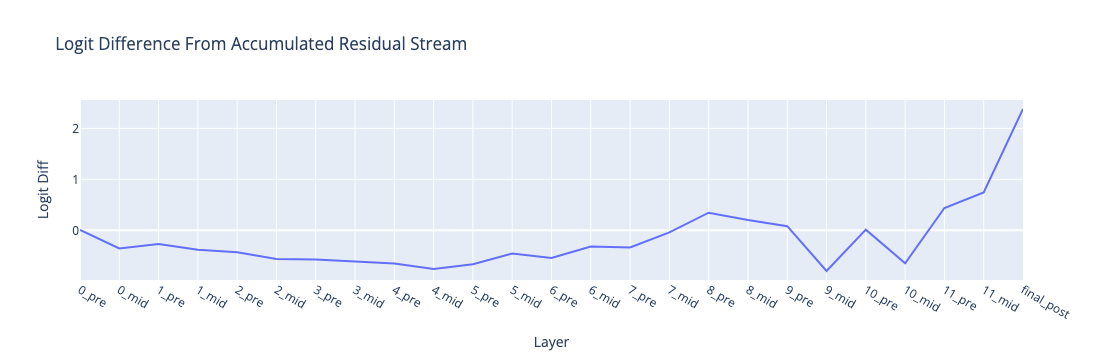

In [349]:
accumulated_residual, labels = cache.accumulated_resid(layer=-1, incl_mid=True, pos_slice=-1, return_labels=True)
# accumulated_residual has shape (component, batch, d_model)

logit_lens_logit_diffs = residual_stack_to_logit_diff(accumulated_residual, cache) # [component]

line(
    logit_lens_logit_diffs, 
    hovermode="x unified",
    title="Logit Difference From Accumulated Residual Stream",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800
)

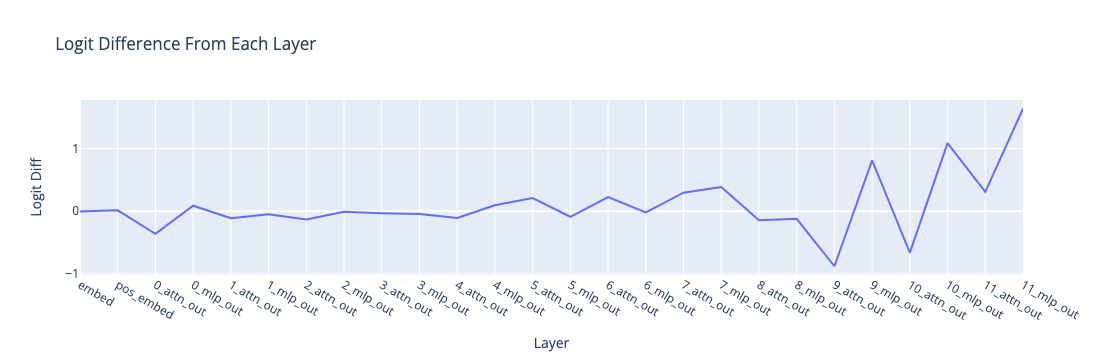

In [350]:
per_layer_residual, labels = cache.decompose_resid(layer=-1, pos_slice=-1, return_labels=True)
per_layer_logit_diffs = residual_stack_to_logit_diff(per_layer_residual, cache)

line(
    per_layer_logit_diffs, 
    hovermode="x unified",
    title="Logit Difference From Each Layer",
    labels={"x": "Layer", "y": "Logit Diff"},
    xaxis_tickvals=labels,
    width=800
)

Tried to stack head results when they weren't cached. Computing head results now


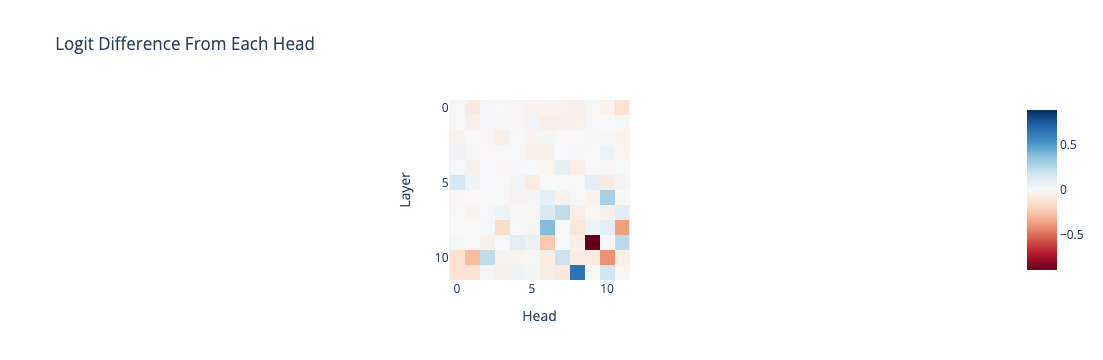

In [351]:
per_head_residual, labels = cache.stack_head_results(layer=-1, pos_slice=-1, return_labels=True)
per_head_residual = einops.rearrange(
    per_head_residual, 
    "(layer head) ... -> layer head ...", 
    layer=model.cfg.n_layers
)
per_head_logit_diffs = residual_stack_to_logit_diff(per_head_residual, cache)

imshow(
    per_head_logit_diffs, 
    labels={"x":"Head", "y":"Layer"}, 
    title="Logit Difference From Each Head",
    width=600
)

In [352]:
def topk_of_Nd_tensor(tensor: Float[Tensor, "rows cols"], k: int):
    '''
    Helper function: does same as tensor.topk(k).indices, but works over 2D tensors.
    Returns a list of indices, i.e. shape [k, tensor.ndim].

    Example: if tensor is 2D array of values for each head in each layer, this will
    return a list of heads.
    '''
    i = t.topk(tensor.flatten(), k).indices
    return np.array(np.unravel_index(utils.to_numpy(i), tensor.shape)).T.tolist()


k = 3

for head_type in ["Positive", "Negative"]:

    # Get the heads with largest (or smallest) contribution to the logit difference
    top_heads = topk_of_Nd_tensor(per_head_logit_diffs * (1 if head_type=="Positive" else -1), k)

    # Get all their attention patterns
    attn_patterns_for_important_heads: Float[Tensor, "head q k"] = t.stack([
        cache["pattern", layer][:, head][0]
        for layer, head in top_heads
    ])

    # Display results
    display(HTML(f"<h2>Top {k} {head_type} Logit Attribution Heads</h2>"))
    display(cv.attention.attention_patterns(
        attention = attn_patterns_for_important_heads,
        tokens = model.to_str_tokens(tokens[0]),
        attention_head_names = [f"{layer}.{head}" for layer, head in top_heads],
    ))

# Activation Patching

In [285]:
from transformer_lens import patching

In [289]:
corrupted_prompts, corrupted_tokens, corrupted_token_length = name_conversion.corrupt_prompt()
clean_tokens = name_conversion.tokens

print(
    "Clean string 0:    ", model.to_string(clean_tokens[0]), "\n"
    "Corrupted string 0:", model.to_string(corrupted_tokens[0])
)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

clean_logit_diff = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print(f"Clean logit diff: {clean_logit_diff:.4f}")

corrupted_logit_diff = logits_to_ave_logit_diff(corrupted_logits, answer_tokens)
print(f"Corrupted logit diff: {corrupted_logit_diff:.4f}")

Clean string 0:     <|endoftext|> Ann Strong -> ann_strong
 Ed Green -> ed_green
 Dawn Wolf -> dawn_wolf
 Princess Little -> princess_little
 Barb Moon -> barb_moon
 Tom Strong -> tom_strong
 Crystal Ho -> 
Corrupted string 0: <|endoftext|> Ann Strong -> Ann_Strong
 Ed Green -> Ed_Green
 Dawn Wolf -> Dawn_Wolf
 Princess Little -> Princess_Little
 Barb Moon -> Barb_Moon
 Tom Strong -> Tom_Strong
 Crystal Ho ->
Clean logit diff: 2.4813
Corrupted logit diff: -7.7278


In [290]:
def ioi_metric(
    logits: Float[Tensor, "batch seq d_vocab"], 
    answer_tokens: Float[Tensor, "batch 2"] = answer_tokens,
    corrupted_logit_diff: float = corrupted_logit_diff,
    clean_logit_diff: float = clean_logit_diff,
) -> Float[Tensor, ""]:
    '''
    Linear function of logit diff, calibrated so that it equals 0 when performance is 
    same as on corrupted input, and 1 when performance is same as on clean input.
    '''
    # SOLUTION
    patched_logit_diff = logits_to_ave_logit_diff(logits, answer_tokens)
    return (patched_logit_diff - corrupted_logit_diff) / (clean_logit_diff  - corrupted_logit_diff)


t.testing.assert_close(ioi_metric(clean_logits).item(), 1.0)
t.testing.assert_close(ioi_metric(corrupted_logits).item(), 0.0)
t.testing.assert_close(ioi_metric((clean_logits + corrupted_logits) / 2).item(), 0.5)

In [ ]:
act_patch_resid_pre = patching.get_act_patch_resid_pre(
    model = model,
    corrupted_tokens = corrupted_tokens,
    clean_cache = clean_cache,
    patching_metric = ioi_metric
)

In [321]:
labels = [f"{tok} {i}" for i, tok in enumerate(model.to_str_tokens(clean_tokens[0]))]

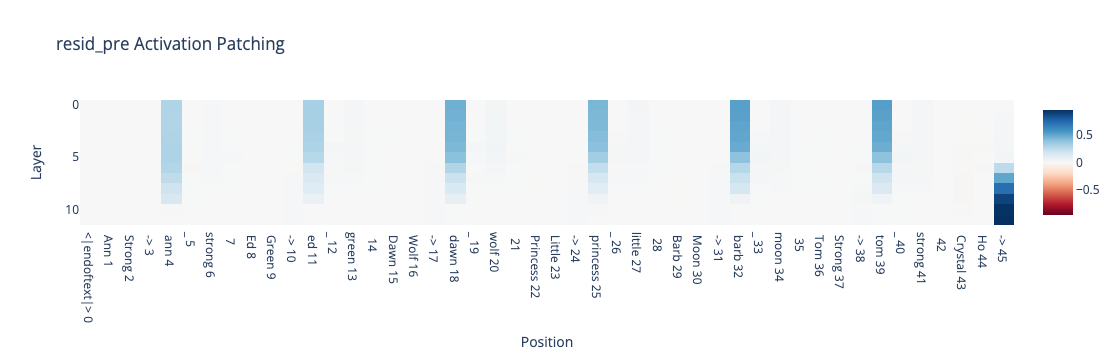

In [ ]:
imshow(
    act_patch_resid_pre, 
    labels={"x": "Position", "y": "Layer"},
    x=labels,
    title="resid_pre Activation Patching",
    width=1200
)

In [ ]:
act_patch_block_every = patching.get_act_patch_block_every(model, corrupted_tokens, clean_cache, ioi_metric)

In [317]:
act_patch_block_every[index,:, :].shape

torch.Size([12, 46])

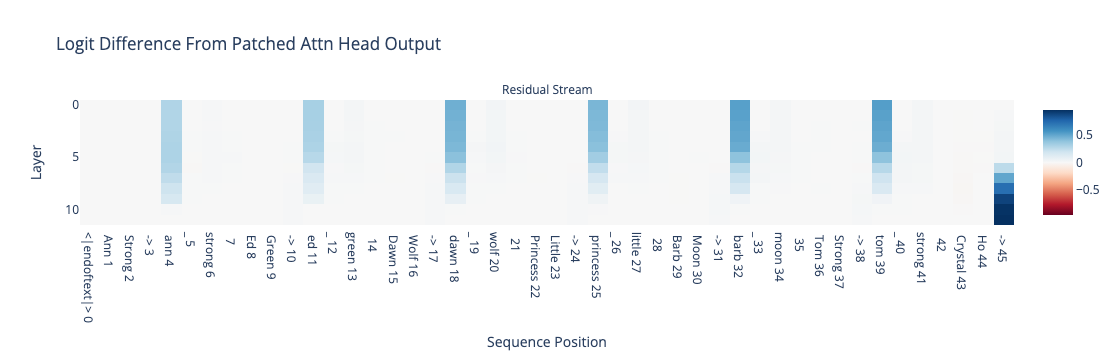

In [314]:
imshow(
    einops.rearrange(act_patch_block_every[0 ,:, :], 'h w -> 1 h w'),
    x=labels, 
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Residual Stream"], # Subtitles of separate plots
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1100,
)

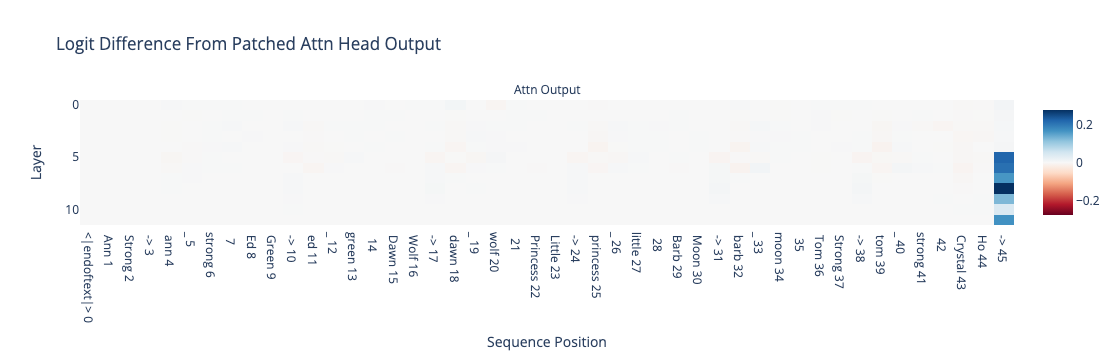

In [322]:
head_labels = ["Residual Stream", "Attn Output", "MLP Output"] 
index = 1
imshow(
    einops.rearrange(act_patch_block_every[1,:, :], 'h w -> 1 h w'),
    x=labels, 
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["Attn Output"], # Subtitles of separate plots
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1100,
)

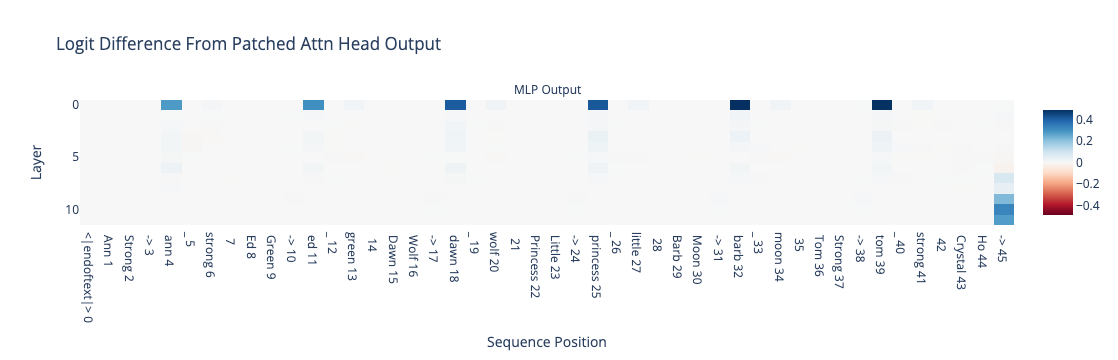

In [323]:
head_labels = ["Residual Stream", "Attn Output", "MLP Output"] 
index = 1
imshow(
    einops.rearrange(act_patch_block_every[2,:, :], 'h w -> 1 h w'),
    x=labels, 
    facet_col=0, # This argument tells plotly which dimension to split into separate plots
    facet_labels=["MLP Output"], # Subtitles of separate plots
    title="Logit Difference From Patched Attn Head Output", 
    labels={"x": "Sequence Position", "y": "Layer"},
    width=1100,
)

  0%|          | 0/144 [00:00<?, ?it/s]

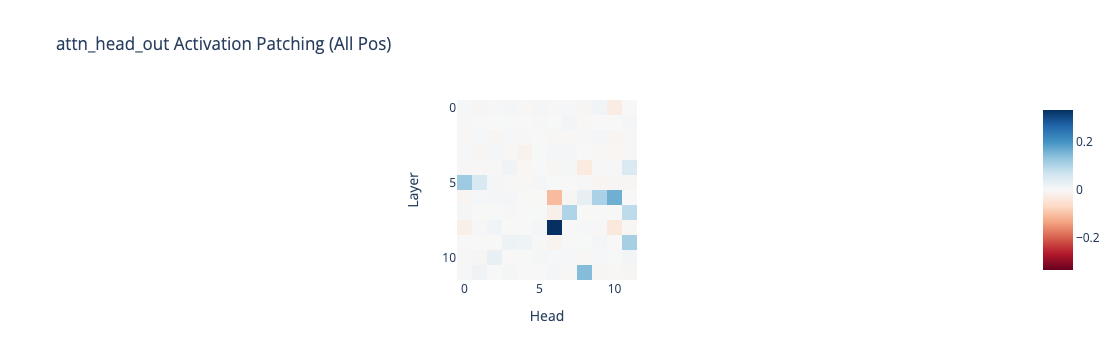

In [295]:
act_patch_attn_head_out_all_pos = patching.get_act_patch_attn_head_out_all_pos(
    model, 
    corrupted_tokens, 
    clean_cache, 
    ioi_metric
)

imshow(
    act_patch_attn_head_out_all_pos, 
    labels={"y": "Layer", "x": "Head"}, 
    title="attn_head_out Activation Patching (All Pos)",
    width=600
)

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/144 [00:00<?, ?it/s]

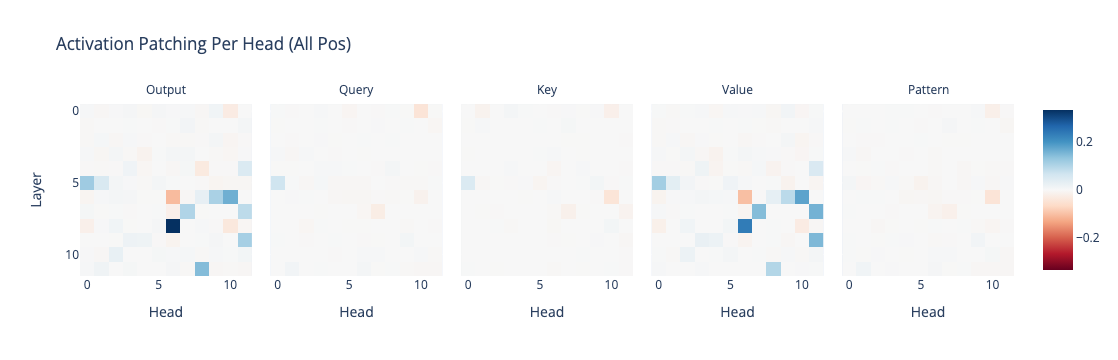

In [296]:
act_patch_attn_head_all_pos_every = patching.get_act_patch_attn_head_all_pos_every(
    model, 
    corrupted_tokens, 
    clean_cache, 
    ioi_metric
)

imshow(
    act_patch_attn_head_all_pos_every, 
    facet_col=0, 
    facet_labels=["Output", "Query", "Key", "Value", "Pattern"],
    title="Activation Patching Per Head (All Pos)", 
    labels={"x": "Head", "y": "Layer"},
)

# Look at Activations

In [140]:
gpt2_tokens = gpt2_small.to_tokens(text)
gpt2_logits, gpt2_cache = gpt2_small.run_with_cache(gpt2_tokens, remove_batch_dim=True)

In [141]:
print(type(gpt2_cache))

gpt2_str_tokens = gpt2_small.to_str_tokens(text)

for layer in range(gpt2_small.cfg.n_layers):

    attention_pattern = gpt2_cache["pattern", layer]
    print(attention_pattern.shape)
    
    print(f"Layer {layer} Head Attention Patterns:")
    display(cv.attention.attention_patterns(
        tokens=gpt2_str_tokens, 
        attention=attention_pattern
    ))

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([12, 52, 52])
Layer 0 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 1 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 2 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 3 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 4 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 5 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 6 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 7 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 8 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 9 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 10 Head Attention Patterns:


torch.Size([12, 52, 52])
Layer 11 Head Attention Patterns:


<span style="color: blue;"> Potentially interesting things going on in 0.1, 0.5, 1.11, 3.0, 4.8, 5.0, 7.11, 9.11, 11.8

### 5.0 seems most interseting

In [165]:
layer = 5
attention_pattern = gpt2_cache["pattern", layer]
print(attention_pattern.shape)

print(f"Layer {layer} Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens, 
    attention=attention_pattern
))

torch.Size([12, 52, 52])
Layer 5 Head Attention Patterns:


In [166]:
head_pattern = gpt2_cache["pattern", 5][0,:,:]

In [167]:
## let's represent text as dataframe to convert index <-> token string more easily
text_df = pd.DataFrame(gpt2_small.to_str_tokens(text)).reset_index()

In [196]:
(head_pattern[14,:] > 0.1).nonzero().squeeze().tolist()

[0, 6, 7]

In [232]:
def get_activation_index(head_layer, head_index, index):
    head_pattern = gpt2_cache["pattern", head_layer][head_index,:,:]
    list_output = (head_pattern[index,:] > 0.1).nonzero().squeeze().tolist()

    # if only one element, it is a int not a list, so convert to list
    if isinstance(list_output, int):
        list_output = list([list_output])
        
    # remove 0 index and current token index
    if 0 in list_output:
        list_output.remove(0)
    if index in list_output:
        list_output.remove(index)

    return list_output

In [212]:
head_layer = 5
head_index = 0
text_df[f"{head_layer}.{head_index}_activation_indices"] = text_df.apply(lambda x: get_activation_index(head_layer, head_index, x["index"]), axis=1)

In [213]:
text_df

index              0 5.0_activation_indices
0       0  <|endoftext|>                      0
1       1              S                      0
2       2          andra                      0
3       3         Medina                      0
4       4             ->                      0
5       5           sand                      0
6       6             ra                      0
7       7              _                      0
8       8            med                      0
9       9            ina                      0
10     10             \n                      0
11     11         Jordan                 [0, 3]
12     12        Alvarez                 [0, 4]
13     13             ->                 [0, 5]
14     14              j              [0, 6, 7]
15     15          ordan                 [0, 7]
16     16              _                 [0, 8]
17     17             al                [0, 10]
18     18              v                [0, 10]
19     19           arez                [0, 10]
20     20             \n                     11
21     21         Joseph                [3, 12]
22     22       Campbell             [0, 4, 13]
23     23             ->                [5, 14]
24     24              j                     15
25     25            ose             [0, 7, 16]
26     26             ph             [0, 7, 16]
27     27              _             [0, 8, 17]
28     28           camp            [0, 10, 20]
29     29           bell            [0, 10, 20]
30     30             \n            [0, 11, 21]
31     31          Laura               [12, 22]
32     32           Mald             [0, 4, 13]
33     33             on                [0, 13]
34     34            ado            [4, 13, 23]
35     35             ->            [5, 14, 24]
36     36              l               [15, 25]
37     37           aura            [0, 16, 27]
38     38              _            [8, 17, 28]
39     39              m                [0, 19]
40     40            ald        [0, 10, 20, 30]
41     41             on        [0, 10, 20, 30]
42     42            ado        [0, 10, 20, 30]
43     43             \n           [11, 21, 31]
44     44           Matt        [0, 12, 22, 32]
45     45            Kim         [0, 4, 13, 23]
46     46             ->        [5, 14, 24, 36]
47     47           matt       [15, 16, 27, 38]
48     48              _     [0, 8, 17, 28, 39]
49     49              k                [0, 40]
50     50             im                      0
51     51             \n    [0, 11, 21, 31, 44]

<span style="color: blue;">
The last name from email format attend to the /n token. <br>
The first name from email format attend to the "_" token or the token right before. <br>
The "_" token looks at the first token after the "_" tokens.

### Let's try looking at the layer 0

In [214]:
layer = 0
attention_pattern = gpt2_cache["pattern", layer]
print(attention_pattern.shape)

print(f"Layer {layer} Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens, 
    attention=attention_pattern
))

torch.Size([12, 52, 52])
Layer 0 Head Attention Patterns:


In [234]:
head_layer = 0
head_index = 1
text_df[f"{head_layer}.{head_index}_activation_indices"] = text_df.apply(lambda x: get_activation_index(head_layer, head_index, x["index"]), axis=1)

In [235]:
text_df[["index", 0, f"{head_layer}.{head_index}_activation_indices"]]

index              0 0.1_activation_indices
0       0  <|endoftext|>                     []
1       1              S                     []
2       2          andra                     []
3       3         Medina                     []
4       4             ->                     []
5       5           sand                     []
6       6             ra                     []
7       7              _                     []
8       8            med                    [3]
9       9            ina                     []
10     10             \n                     []
11     11         Jordan                     []
12     12        Alvarez                     []
13     13             ->                    [4]
14     14              j                     []
15     15          ordan                   [11]
16     16              _                    [7]
17     17             al                     []
18     18              v                     []
19     19           arez                   [12]
20     20             \n                   [10]
21     21         Joseph                     []
22     22       Campbell                     []
23     23             ->                [4, 13]
24     24              j                   [14]
25     25            ose                     []
26     26             ph                     []
27     27              _                [7, 16]
28     28           camp                   [22]
29     29           bell                   [22]
30     30             \n               [10, 20]
31     31          Laura                     []
32     32           Mald                     []
33     33             on                     []
34     34            ado                     []
35     35             ->            [4, 13, 23]
36     36              l                     []
37     37           aura                     []
38     38              _            [7, 16, 27]
39     39              m                     []
40     40            ald                   [32]
41     41             on                   [33]
42     42            ado                   [34]
43     43             \n               [20, 30]
44     44           Matt                     []
45     45            Kim                     []
46     46             ->           [13, 23, 35]
47     47           matt                   [44]
48     48              _           [16, 27, 38]
49     49              k                     []
50     50             im                     []
51     51             \n           [20, 30, 43]

<span style="color: blue;">
head 0.1 learns to look at previous "_" and " ->" tokens <br>
Sometimes, the email format names attends to the actual name

In [236]:
head_layer = 0
head_index = 5
text_df[f"{head_layer}.{head_index}_activation_indices"] = text_df.apply(lambda x: get_activation_index(head_layer, head_index, x["index"]), axis=1)

In [237]:
text_df[["index", 0, f"{head_layer}.{head_index}_activation_indices"]]

index              0 0.5_activation_indices
0       0  <|endoftext|>                     []
1       1              S                     []
2       2          andra                     []
3       3         Medina                     []
4       4             ->                     []
5       5           sand                     []
6       6             ra                     []
7       7              _                     []
8       8            med                     []
9       9            ina                     []
10     10             \n                     []
11     11         Jordan                     []
12     12        Alvarez                     []
13     13             ->                    [4]
14     14              j                     []
15     15          ordan                     []
16     16              _                    [7]
17     17             al                     []
18     18              v                     []
19     19           arez                     []
20     20             \n                   [10]
21     21         Joseph                     []
22     22       Campbell                     []
23     23             ->                [4, 13]
24     24              j                   [14]
25     25            ose                     []
26     26             ph                     []
27     27              _                [7, 16]
28     28           camp                     []
29     29           bell                     []
30     30             \n               [10, 20]
31     31          Laura                     []
32     32           Mald                     []
33     33             on                     []
34     34            ado                     []
35     35             ->            [4, 13, 23]
36     36              l                     []
37     37           aura                     []
38     38              _            [7, 16, 27]
39     39              m                     []
40     40            ald                     []
41     41             on                   [33]
42     42            ado                   [34]
43     43             \n           [10, 20, 30]
44     44           Matt                     []
45     45            Kim                     []
46     46             ->        [4, 13, 23, 35]
47     47           matt                     []
48     48              _        [7, 16, 27, 38]
49     49              k                     []
50     50             im                     []
51     51             \n       [10, 20, 30, 43]

<span style="color: blue;">
head 0.5 learns to look at previous "_" and " ->" tokens

## Let's try looking at layer 1

In [221]:
layer = 1
attention_pattern = gpt2_cache["pattern", layer]
print(attention_pattern.shape)

print(f"Layer {layer} Head Attention Patterns:")
display(cv.attention.attention_patterns(
    tokens=gpt2_str_tokens, 
    attention=attention_pattern
))

torch.Size([12, 52, 52])
Layer 1 Head Attention Patterns:


In [233]:
head_layer = 1
head_index = 11
text_df[f"{head_layer}.{head_index}_activation_indices"] = text_df.apply(lambda x: get_activation_index(head_layer, head_index, x["index"]), axis=1)

text_df[["index", 0, f"{head_layer}.{head_index}_activation_indices"]]

index              0 1.11_activation_indices
0       0  <|endoftext|>                      []
1       1              S                      []
2       2          andra                      []
3       3         Medina                      []
4       4             ->                      []
5       5           sand                      []
6       6             ra                      []
7       7              _                      []
8       8            med                      []
9       9            ina                      []
10     10             \n                      []
11     11         Jordan                      []
12     12        Alvarez                      []
13     13             ->                     [4]
14     14              j                      []
15     15          ordan                    [11]
16     16              _                     [7]
17     17             al                      []
18     18              v                      []
19     19           arez                      []
20     20             \n                    [10]
21     21         Joseph                      []
22     22       Campbell                      []
23     23             ->                 [4, 13]
24     24              j                    [14]
25     25            ose                      []
26     26             ph                      []
27     27              _                 [7, 16]
28     28           camp                    [22]
29     29           bell                    [22]
30     30             \n                [10, 20]
31     31          Laura                      []
32     32           Mald                      []
33     33             on                      []
34     34            ado                      []
35     35             ->                [13, 23]
36     36              l                      []
37     37           aura                      []
38     38              _                [16, 27]
39     39              m                      []
40     40            ald                      []
41     41             on                    [33]
42     42            ado                    [34]
43     43             \n                [20, 30]
44     44           Matt                      []
45     45            Kim                      []
46     46             ->                [23, 35]
47     47           matt                    [44]
48     48              _                [27, 38]
49     49              k                      []
50     50             im                      []
51     51             \n                [30, 43]

<span style="color: blue;">
head 1.11 learns to look at previous "_" and " ->" tokens, but only the two previous ones (not all) <br>
\n looks at previous two \n tokens <br>
 name in email format sometimes attends to the original  name

In [274]:
def logit_attribution(
    embed: Float[Tensor, "seq d_model"],
    l1_results: Float[Tensor, "seq nheads d_model"],
    l2_results: Float[Tensor, "seq nheads d_model"],
    W_U: Float[Tensor, "d_model d_vocab"],
    tokens: Int[Tensor, "seq"]
) -> Float[Tensor, "seq-1 n_components"]:
    '''
    Inputs:
        embed: the embeddings of the tokens (i.e. token + position embeddings)
        l1_results: the outputs of the attention heads at layer 1 (with head as one of the dimensions)
        l2_results: the outputs of the attention heads at layer 2 (with head as one of the dimensions)
        W_U: the unembedding matrix
        tokens: the token ids of the sequence

    Returns:
        Tensor of shape (seq_len-1, n_components)
        represents the concatenation (along dim=-1) of logit attributions from:
            the direct path (seq-1,1)
            layer 0 logits (seq-1, n_heads)
            layer 1 logits (seq-1, n_heads)
        so n_components = 1 + 2*n_heads
    '''
    W_U_correct_tokens = W_U[:, tokens[1:]]

    embed_comp = einops.einsum(embed[:-1], W_U_correct_tokens, "seq d_model, d_model seq -> seq")
    embed_comp = einops.rearrange(embed_comp, 'seq -> seq 1')
    l1_results_comp = einops.einsum(l1_results[:-1], W_U_correct_tokens, "seq nheads d_model, d_model seq -> seq nheads")
    l2_results_comp = einops.einsum(l2_results[:-1], W_U_correct_tokens, "seq nheads d_model, d_model seq -> seq nheads")
    
    return t.cat((embed_comp, l1_results_comp, l2_results_comp), -1)

# logits, cache = model.run_with_cache(text, remove_batch_dim=True)
# str_tokens = model.to_str_tokens(text)
# tokens = model.to_tokens(text)

with t.inference_mode():
    embed = gpt2_cache["embed"]
    l1_results = gpt2_cache["result", 0]
    l2_results = gpt2_cache["result", 1]
    logit_attr = logit_attribution(embed, l1_results, l2_results, model.W_U, tokens[0])
    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, t.arange(len(tokens[0]) - 1), tokens[0, 1:]]
    t.testing.assert_close(logit_attr.sum(1), correct_token_logits, atol=1e-3, rtol=0)
    print("Tests passed!")

KeyError: 'blocks.0.attn.hook_result'

In [275]:
gpt2_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re